In [24]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, plot_importance, plot_tree
from sklearn.metrics import (accuracy_score, mean_absolute_error,
                             mean_squared_error, r2_score)

from time import time
%matplotlib inline

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2ca6805d30>,
      dtype=object)

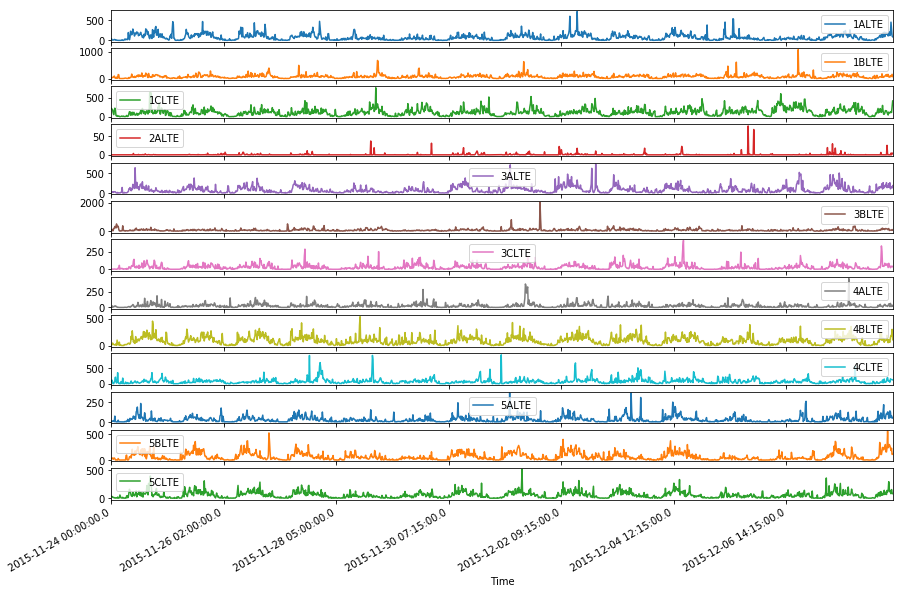

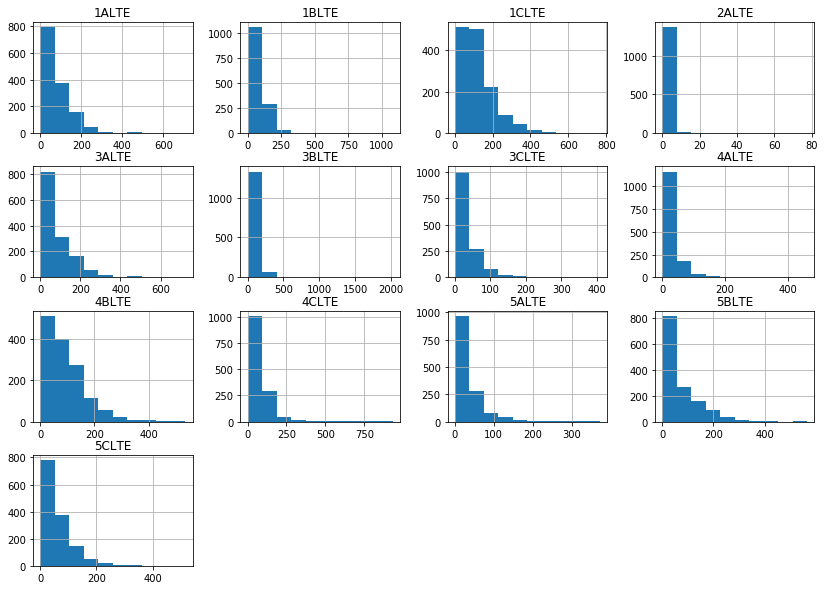

In [2]:
# import dataset in a pandas dataframe
df = pd.read_csv("dataset.csv", index_col=0)
df = df.dropna()
df.plot(subplots=True, figsize=(14,10))
df.hist(figsize=(14,10))

In [81]:
#suppose with want to make a prediction for "4BLTE"
# its index is 8

def split_sequences(sequences, n_steps, idx_array):
    X, target = list(), list()
    for i in range(len(sequences)):
        #find the end of the subsequence
        end_ix = i + n_steps
        if end_ix > len(sequences) - 1:
            break
        #gather input and output parts of the subsequence
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        target.append(np.where(seq_x[-1, idx_array]<seq_y[idx_array], 1, 0))
        X.append(seq_x)
    return np.array(X), np.array(target)
        
        

In [82]:
LOOKBACK = 2
IDX_ARRAY = 8

In [83]:
scaler = MinMaxScaler()
series = scaler.fit_transform(df.values)


In [100]:
X, y = split_sequences(series, n_steps=LOOKBACK, idx_array=IDX_ARRAY )


In [101]:
# Function that creates model change according to needs
def create_model():
    inputs = Input(shape=X.shape[1:])

    y = GRU(128)(inputs)
    y = Dropout(0.5)(y)

    out = Dense(2, activation='softmax')(y)
    


    model = Model(inputs, out)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [102]:
def kfold_validation(n_splits):
    kf = KFold(n_splits=n_splits)

    model = KerasClassifier(build_fn=create_model, epochs=20, batch_size=64, verbose=0)

    scores = cross_val_score(model, X, y, cv=kf, n_jobs=-1)
    
    return scores


In [103]:
def evaluate_score(score):
    mean = np.mean(score)
    std = np.std(score)
    print(f"Average score:{mean}+/-{std}%")
    plt.boxplot(scores)


In [104]:
scores = kfold_validation(10)

AttributeError: 'Model' object has no attribute 'predict_proba'

In [ ]:
evaluate_score(scores)

Average score:0.7390690260372975+/-0.024850122942459134%


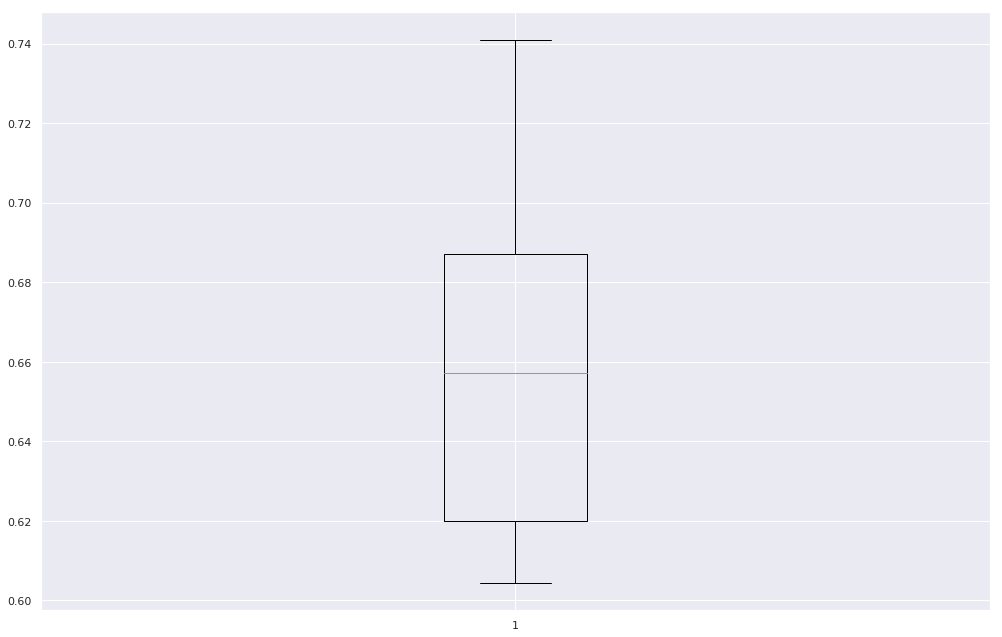

In [105]:
kf = KFold(n_splits=10)
X, y = split_sequences(series, LOOKBACK, IDX_ARRAY)

X = X.reshape(X.shape[0], X.shape[1]*X.shape[2])

start = time()
model = XGBClassifier(nthread=-1)
results = cross_val_score(model, X, y, cv=kf, scoring='roc_auc', n_jobs=-1)
elapsed = time() - start
evaluate_score(results)